# A Simple Model

In [1]:
import pandas as pd
from sklearn import base
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import joblib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

In [2]:
from typing import List, Union, Tuple, Dict

In [3]:
RANDOM_STATE = 42

In [4]:
train_df_path = "data/train.csv"
test_df_path = "data/test.csv"

Here are the features in the data:

```
survived - Survival (0 = No; 1 = Yes)
class - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
name - Name
sex - Sex
age - Age
sibsp - Number of Siblings/Spouses Aboard
parch - Number of Parents/Children Aboard
ticket - Ticket Number
fare - Passenger Fare
cabin - Cabin
embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
boat - Lifeboat (if survived)
body - Body number (if did not survive and body was recovered)
```

In [5]:
# Constant
index_col = 'passengerid'
drop_cols = ["name", "sibsp", "parch", "ticket"]
target_col = "survived"
target_names = ["died", target_col]
cat_cols = ["sex", "cabin", "embarked"]

## Functions

In [6]:
def _sanitize_columns(
    df_columns: List[str] # the current column names
) -> List[str]: # sanitized column names
    return [c.strip().replace("/", "_per_").replace(" ", "_").lower() for c in df_columns]

In [7]:
cols = 'PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked'.strip().split(',')
_sanitize_columns(cols)

['passengerid',
 'survived',
 'pclass',
 'name',
 'sex',
 'age',
 'sibsp',
 'parch',
 'ticket',
 'fare',
 'cabin',
 'embarked']

In [8]:
cols_test = list(set(cols) - set(['Survived']))

In [9]:
_sanitize_columns(["hello world","revenue/user", "CamelCase"])

['hello_world', 'revenue_per_user', 'camelcase']

### for Feature Engineering

In [23]:
# print("Engineering features...")
# y = df_train[obj_col]
# train_df = feature_engineering(df_train).drop(drop_cols + [obj_col], axis=1)
# test_df = feature_engineering(df_test).drop(drop_cols, axis=1)
# train_df, test_df, mappings = to_category(train_df, test_df)

In [24]:
def input_data(
    raw_data: pd.DataFrame, # just loaded raw dataframe, could be fron anywhere
    cols: List[str], # columns from the dataframe to consider and sanitize. Must contain index_col.
    index_col: str # column to use as unique index
) -> pd.DataFrame: # sanitized dataframe
    df = raw_data.copy()[cols]
    df.columns = _sanitize_columns(cols)
    return df.set_index(index_col)

In [25]:
def target(
    input_data: pd.DataFrame, # input dataframe,
    target_col: str # this is the column that we want from the dataframe
) -> pd.Series: # return series corresponding to target
    return input_data[target_col]

In [26]:
def features(
    input_data: pd.DataFrame, # input dataframe,
    target_col: str, # this is the column that we want to take out from the dataframe
) -> pd.DataFrame: # return dataframe corresponding to the feature matrix
    if target_col in input_data.columns:
        return input_data.drop([target_col], axis=1)
    return input_data

In [27]:
def cabin_t(
    cabin: pd.Series # raw cabin info
) -> pd.Series: # transformed cabin info
    return cabin.apply(lambda x: x[:1] if x is not np.nan else np.nan)

In [28]:
def ticket_t(
    ticket: pd.Series # raw ticket number
) -> pd.Series: # transformed ticket number
    return ticket.apply(lambda x: str(x).split()[0])

In [29]:
def family(
    sibsp: pd.Series, # number of siblings
    parch: pd.Series # number of parents/children
) -> pd.Series: # number of people in family
    return sibsp + parch

In [30]:
def _label_encoder(
    input_series: pd.Series # series to categorize
) -> preprocessing.LabelEncoder: # sklearn label encoder
    le = preprocessing.LabelEncoder()
    le.fit(input_series)
    return le

In [31]:
def _label_transformer(
    fit_le: preprocessing.LabelEncoder, # a fit label encoder
    input_series: pd.Series # series to transform 
) -> pd.Series: # transformed series
    return fit_le.transform(input_series)

In [32]:
def transformed_features(
    universe: pd.DataFrame, # a dataframe with categorical columns that capture all categorical levels
    features: pd.DataFrame, # input feature matrix
    cat_cols: List[str], # columns to categorize)
    cabin_t: pd.Series, # transformed cabin number
    ticket_t: pd.Series, # transformed ticket number
    labelencoders = Union[List[preprocessing.LabelEncoder], None] # Label Encoders if fit, else None
) -> Tuple[pd.DataFrame, List[preprocessing.LabelEncoder]] : # engineered features and labelencoders
    df = features.copy().drop(['cabin', 'ticket']+cat_cols, axis=1)
    df['cabin'] = cabin_t
    df['ticket'] = ticket_t
    if labelencoders is None:
        les = [None]*len(cat_cols)
    else:
        les = labelencoders
    againles = []
    for col, le in zip(cat_cols, les):
        if le == None:
            le = _label_encoder(universe[col])
        df[col] = _label_transformer(le, features[col])
        againles.append(le)
    return df, againles

In [33]:
def engineered_features(
    transformed_features: pd.DataFrame, # feature matrix with some columns trandformed
    family: pd.Series, # newly creates family column
) -> pd.DataFrame: # dataframe with dropped columns ready to feed into model
    df = transformed_features.copy()
    df['family'] = family
    return df

In [34]:
def dropped_features(
    engineered_features: pd.DataFrame, # feature matrix with engineered features added in
    drop_cols: List[str], # these are the columns we want to drop
) -> pd.DataFrame: # dataframe with dropped columns
    df = engineered_features.copy()
    return df.drop(drop_cols, axis=1)



In [35]:
def final_imputed_features(
    dropped_features: pd.DataFrame, # feature matrix with features dropped
) -> pd.DataFrame: # dataframe with imputed columns ready to feed into model
    df = dropped_features.copy()
    return df.fillna(0)

### for Data Splits

In [36]:
def train_valid_split_func(
    final_imputed_features: pd.DataFrame, # feature matrix
    target: pd.Series, # the target or the y
    validation_size_fraction: float, # the validation fraction
    random_state: int, # random state for reproducibility
    stratify: pd.Series, # series whose values we use to stratify by
) -> Tuple[List[pd.DataFrame], List[pd.Series]]: # dictionary of dataframes and Series
    """Function that creates the training & test splits.
    It this then extracted out into constituent components and used downstream.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        final_imputed_features, target, test_size=validation_size_fraction, stratify=stratify
    )
    return [X_train, X_test], [y_train, y_test]


## Working On Actual Data

Our test set here actually has no ground truth. We'll thus use the original training set and split it up into train and validation. 

In [37]:
def data__csv(
    path: str # path to csv file
) -> pd.DataFrame: # dataframe read from csv file
    return pd.read_csv(path)

In [38]:
print("Loading data...")
df_train = data__csv(train_df_path)
inputdata = input_data(df_train, cols, index_col)
inputdata

Loading data...


,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
passengerid,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
99995,1,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C
99996,0,2,"Brown, Herman",male,66.00,0,0,13273,11.15,NaN,S
99997,0,3,"Childress, Charles",male,37.00,0,0,NaN,9.95,NaN,S


In [39]:
df_test = data__csv(test_df_path)

### Feature Engineering

In [40]:
y = target(inputdata, target_col)
y

passengerid
0        1
1        0
2        0
3        0
4        1
        ..
99995    1
99996    0
99997    0
99998    0
99999    0
Name: survived, Length: 100000, dtype: int64

In [41]:
X = features(inputdata, target_col)
X

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
passengerid,,,,,,,,,,
0,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
...,...,...,...,...,...,...,...,...,...,...
99995,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C
99996,2,"Brown, Herman",male,66.00,0,0,13273,11.15,NaN,S
99997,3,"Childress, Charles",male,37.00,0,0,NaN,9.95,NaN,S


In [42]:
testdata = features(input_data(df_test, cols_test, index_col), target_col)
testdata

,sex,ticket,embarked,parch,cabin,age,pclass,fare,name,sibsp
passengerid,,,,,,,,,,
100000,male,24745,S,0,NaN,19.0,3,63.01,"Holliday, Daniel",0
100001,female,13264,S,0,NaN,53.0,3,5.81,"Nguyen, Lorraine",0
100002,female,25990,C,0,B15315,19.0,1,38.91,"Harris, Heather",0
100003,male,314011,S,0,NaN,25.0,2,12.93,"Larsen, Eric",0
100004,female,26203,C,2,B22515,17.0,1,26.89,"Cleary, Sarah",0
...,...,...,...,...,...,...,...,...,...,...
199995,female,7686,Q,0,NaN,27.0,3,10.12,"Cash, Cheryle",0
199996,male,13004,S,0,NaN,59.0,1,68.31,"Brown, Howard",1
199997,male,4383317,S,0,NaN,47.0,3,10.87,"Lightfoot, Cameron",0


In [43]:
Xtrans, les = transformed_features(
    pd.concat([X[cat_cols], testdata[cat_cols]], axis=0),
    X,
    cat_cols,
    cabin_t(X.cabin),
    ticket_t(X.ticket),
    None
) 

In [44]:
les

[LabelEncoder(), LabelEncoder(), LabelEncoder()]

In [45]:
Xeng = engineered_features(
    Xtrans,
    family(Xtrans.sibsp, Xtrans.parch),
)

In [46]:
Xdrop = dropped_features(
    Xeng,
    drop_cols
)

In [47]:
Xfinal = final_imputed_features(Xdrop)
Xfinal

,pclass,age,fare,cabin,sex,embarked,family
passengerid,,,,,,,
0,1,0.00,27.14,22424,1,2,2
1,3,0.00,13.35,45442,1,2,0
2,3,0.33,71.29,45442,1,2,3
3,3,19.00,13.04,45442,1,2,0
4,3,25.00,7.76,45442,1,2,0
...,...,...,...,...,...,...,...
99995,2,62.00,14.86,35404,0,0,0
99996,2,66.00,11.15,45442,1,2,0
99997,3,37.00,9.95,45442,1,2,0


In [48]:
for col in ['pclass', 'sex', 'cabin', 'embarked', 'family']:
    print(col, Xfinal[col].unique())

pclass [1 3 2]
sex [1 0]
cabin [22424 45442  8550 ... 34213 42249 35404]
embarked [2 0 1 3]
family [ 2  0  3  1  4  6  5  9  7 10  8 13 11 17 12 14]


### Train-Validation Split

In [49]:
[X_train, X_valid], [y_train, y_valid] = train_valid_split_func(
    Xfinal, y, validation_size_fraction=0.33, random_state=RANDOM_STATE, stratify=y
)

In [50]:
X_train.head()

,pclass,age,fare,cabin,sex,embarked,family
passengerid,,,,,,,
65444,3,33.0,13.10,45442,1,2,0
57472,3,35.0,9.81,45442,1,2,0
49,3,22.0,9.29,45442,1,1,3
34252,1,36.0,59.73,22829,0,2,0
77652,3,20.0,27.75,12553,1,2,3


## More Functions

### for Training

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
def prefit_clf__rf(
    random_state: int, # get random state from parameters
    max_depth: Union[int, None] # either None or given max_depth hyperparameter
) -> base.ClassifierMixin: # return an unfit Random Forest
    return RandomForestClassifier(max_depth = max_depth, random_state = random_state)

In [53]:
def fit_clf(
    prefit_clf: base.ClassifierMixin, # prefit classifier
    X_train: pd.DataFrame, # transformed features matrix
    y_train: pd.Series, # target column
) -> base.ClassifierMixin:
    """Calls fit on the classifier object; it mutates the classifier and fits it."""
    prefit_clf.fit(X_train, y_train)
    return prefit_clf

In [54]:
import joblib
def write_model(
    fit_clf: base.ClassifierMixin, # already fit classifier
    modelpath: Path # folder for model
) -> None:
    joblib.dump(fit_clf, f"{modelpath}/model.joblib")

### for Predictions

In [55]:
def predictions(
    fit_clf: base.ClassifierMixin, # already fit classifier
    X:pd.DataFrame, # training or testing dataframe
    t:float = 0.5 # classification probability threshold
) -> Tuple[float, int]: # Probabilities from model, Predictions from model
    y_proba = fit_clf.predict_proba(X)[:, 1]
    y_preds  = 1*(y_proba >= t)
    return y_proba, y_preds

### for Metrics and Plots

In [56]:
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
)
import json

In [57]:
def metrics_noproba(
    y: pd.Series, # actual values
    ypred: pd.Series # predictions based on some threshold
) -> Dict[str, float]:
    return {
        "accuracy": accuracy_score(y, ypred),
        "precision": precision_score(y, ypred),
        "recall": recall_score(y, ypred),
        "f1": f1_score(y, ypred)    }

In [58]:
def plots_noproba(
    y: pd.Series, # actual values
    ypred: pd.Series # predictions based on some threshold
) -> Dict[str, object]:    
    cm = confusion_matrix(y, ypred)
    cm_plot = ConfusionMatrixDisplay(cm)
    return {
        'cm': cm_plot
    }

In [59]:
def metrics(
    y: pd.Series, # actual values
    ypred: pd.Series, # predictions based on some threshold
    yproba: pd.Series # probability values
) -> Dict[str, float]:
    return {
        "roc_auc": roc_auc_score(y, yproba),
        "average_precision": average_precision_score(y, yproba),
        "accuracy": accuracy_score(y, ypred),
        "precision": precision_score(y, ypred),
        "recall": recall_score(y, ypred),
        "f1": f1_score(y, ypred)
    }

In [60]:
def write_metrics(
    metrics: Dict[str, object], # dictionary of metrics
    modelpath: Path, # model folder to write to
    context: str # train or test, with hyperparams and run_id if appropriate
) -> None:
    with open(modelpath/f"{context}.json", "w") as fd:
        fd.write(json.dumps(metrics))

In [61]:
def plots(
    y: pd.Series, # actual values
    ypred: pd.Series, # predictions based on some threshold
    yproba: pd.Series # probability values
) -> Dict[str, object]:
    cm = confusion_matrix(y, ypred)
    cm_plot = ConfusionMatrixDisplay(cm)
    fpr, tpr, _ = roc_curve(y, yproba)
    roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr)
    prec, recall, _ = precision_recall_curve(y, yproba)
    pr_plot = PrecisionRecallDisplay(precision=prec, recall=recall)
    return {
        'cm': cm_plot,
        'roc': roc_plot,
        'pr': pr_plot
    }

In [62]:
def write_plots(
    plots: Dict[str, object], # dictionary of metrics
    modelpath: Path, # model folder to write to
    context: str # train or test, with hyperparams and run_id if appropriate
) -> None:
    for plot_type in plots:
        plots[plot_type].plot()
        plots[plot_type].figure_.savefig(f"{modelpath}/{plot_type}_{context}.png")

## Model Training

In [63]:
artpath = Path("./artifacts")

### Very Baseline Model

In [64]:
np.mean(y_train), np.mean(y_valid)

(0.42774626865671644, 0.42772727272727273)

Everyone Dies

In [65]:
mname = "everybody_dies"
mpath = Path(artpath/mname)
mpath.mkdir(parents=True, exist_ok=True)
mpath

PosixPath('artifacts/everybody_dies')

In [66]:
!ls -l artifacts/

total 0
drwxr-xr-x  2 rahul  staff  64 Nov 18 12:18 everybody_dies


In [67]:
metrics_train_alldie = metrics_noproba(y_train, np.ones(y_train.size))
metrics_valid_alldie = metrics_noproba(y_valid, np.ones(y_valid.size))
print("TRAIN/ALLDIE", metrics_train_alldie)
write_metrics(metrics_train_alldie, mpath, "train")
print("VALID/ALLDIE", metrics_valid_alldie)
write_metrics(metrics_valid_alldie, mpath, "valid")



TRAIN/ALLDIE {'accuracy': 0.42774626865671644, 'precision': 0.42774626865671644, 'recall': 1.0, 'f1': 0.5991908759238546}
VALID/ALLDIE {'accuracy': 0.42772727272727273, 'precision': 0.42772727272727273, 'recall': 1.0, 'f1': 0.5991722381407195}


In [68]:
mname = "noone_dies"
mpath = Path(artpath/mname)
mpath.mkdir(parents=True, exist_ok=True)
mpath

PosixPath('artifacts/noone_dies')

In [69]:
metrics_train_nonedie = metrics_noproba(y_train, np.zeros(y_train.size))
metrics_valid_nonedie = metrics_noproba(y_valid, np.zeros(y_valid.size))
print("TRAIN/NONEDIE", metrics_train_nonedie)
write_metrics(metrics_train_nonedie, mpath, "train")
print("VALID/NONEDIE", metrics_valid_nonedie)
write_metrics(metrics_valid_nonedie, mpath, "valid")

TRAIN/NONEDIE {'accuracy': 0.5722537313432836, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
VALID/NONEDIE {'accuracy': 0.5722727272727273, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}


/Users/rahul/miniforge3/envs/ml1-arm64/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rahul/miniforge3/envs/ml1-arm64/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Baseline Model

In [70]:
prefit_rf = prefit_clf__rf(
    random_state = RANDOM_STATE,
    max_depth = None
)
rf = fit_clf(prefit_rf, X_train, y_train)

### Baseline Model Predictions

In [71]:
trainproba, trainpreds = predictions(rf, X_train)
validproba, validpreds = predictions(rf, X_valid)

In [72]:
mname = "baseline_rf"
mpath = Path(artpath/mname)
mpath.mkdir(parents=True, exist_ok=True)
mpath

PosixPath('artifacts/baseline_rf')

In [73]:
write_metrics(dict(max_depth=None, random_state=RANDOM_STATE), mpath, "params")

#### Baseline Model Metrics and Plots

In [74]:
train_metrics = metrics(y_train, trainpreds, trainproba)
train_plots = plots(y_train, trainpreds, trainproba)
print(train_metrics)

{'roc_auc': 0.9998462502393908, 'average_precision': 0.9998050550493748, 'accuracy': 0.9954776119402985, 'precision': 0.9977181773502773, 'recall': 0.991695453435221, 'f1': 0.9946976988362937}


In [75]:
write_metrics(train_metrics, mpath, "train")

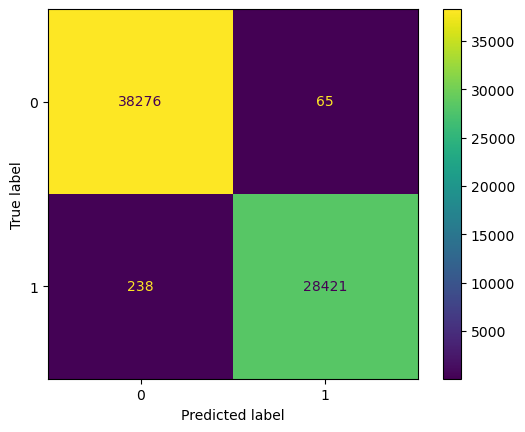

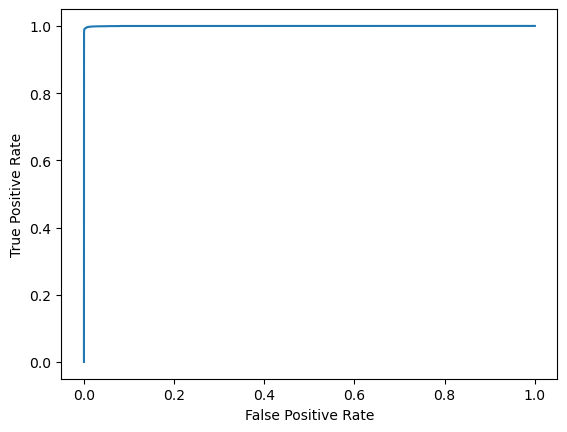

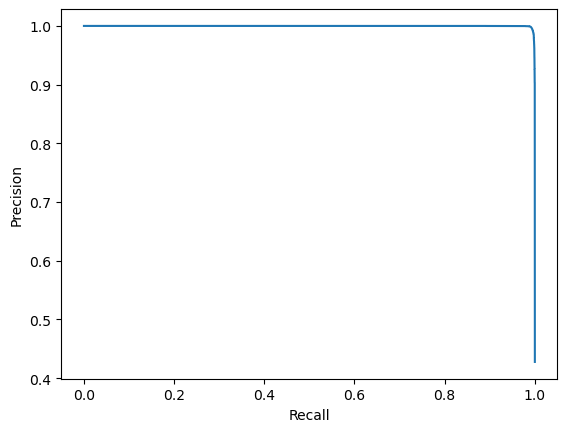

In [76]:
write_plots(train_plots, mpath, "train")

In [77]:
valid_metrics = metrics(y_valid, validpreds, validproba)
valid_plots = plots(y_valid, validpreds, validproba)
print("Validation metrics:")
print(valid_metrics)

Validation metrics:
{'roc_auc': 0.8087066590849343, 'average_precision': 0.7468505126400189, 'accuracy': 0.7430606060606061, 'precision': 0.6996599121439705, 'recall': 0.6996103436060928, 'f1': 0.6996351269970597}


In [78]:
write_metrics(valid_metrics, mpath, "valid")

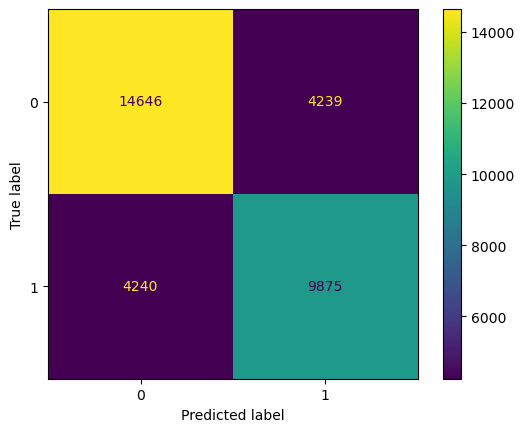

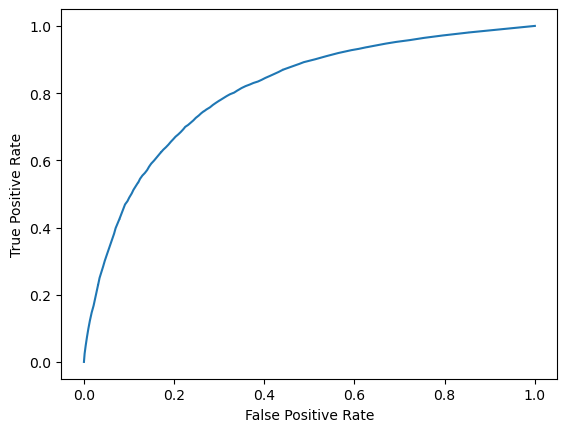

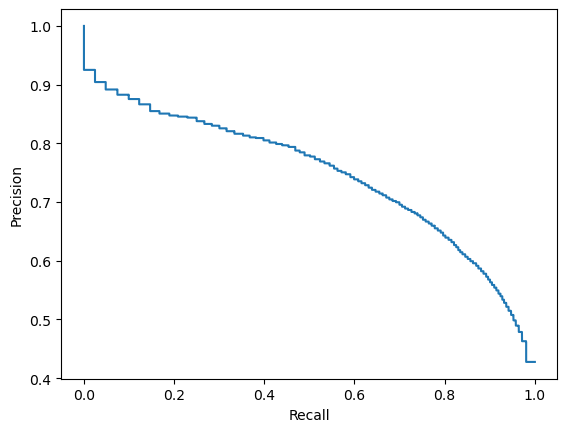

In [79]:
write_plots(valid_plots, mpath, "train")

In [80]:
write_model(rf, mpath)

In [81]:
!ls -lRh artifacts

total 0
drwxr-xr-x  9 rahul  staff   288B Nov 18 12:23 baseline_rf
drwxr-xr-x  4 rahul  staff   128B Nov 18 12:18 everybody_dies
drwxr-xr-x  4 rahul  staff   128B Nov 18 12:19 noone_dies

artifacts/baseline_rf:
total 397888
-rw-r--r--  1 rahul  staff    17K Nov 18 12:23 cm_train.png
-rw-r--r--  1 rahul  staff   194M Nov 18 12:23 model.joblib
-rw-r--r--  1 rahul  staff    39B Nov 18 12:22 params.json
-rw-r--r--  1 rahul  staff    18K Nov 18 12:23 pr_train.png
-rw-r--r--  1 rahul  staff    20K Nov 18 12:23 roc_train.png
-rw-r--r--  1 rahul  staff   192B Nov 18 12:22 train.json
-rw-r--r--  1 rahul  staff   193B Nov 18 12:23 valid.json

artifacts/everybody_dies:
total 16
-rw-r--r--  1 rahul  staff   108B Nov 18 12:18 train.json
-rw-r--r--  1 rahul  staff   108B Nov 18 12:18 valid.json

artifacts/noone_dies:
total 16
-rw-r--r--  1 rahul  staff    76B Nov 18 12:19 train.json
-rw-r--r--  1 rahul  staff    76B Nov 18 12:19 valid.json


### Baseline Model Inference as a separate pipeline

In [82]:
transtestdata, les = transformed_features(
    pd.concat([X[cat_cols], testdata[cat_cols]], axis=0),
    testdata,
    cat_cols,
    cabin_t(testdata.cabin),
    ticket_t(testdata.ticket),
    les
)
transtestdata

,parch,age,pclass,fare,name,sibsp,cabin,ticket,sex,embarked
passengerid,,,,,,,,,,
100000,0,19.0,3,63.01,"Holliday, Daniel",0,45442,24745,1,2
100001,0,53.0,3,5.81,"Nguyen, Lorraine",0,45442,13264,0,2
100002,0,19.0,1,38.91,"Harris, Heather",0,13085,25990,0,0
100003,0,25.0,2,12.93,"Larsen, Eric",0,45442,314011,1,2
100004,2,17.0,1,26.89,"Cleary, Sarah",0,16911,26203,0,0
...,...,...,...,...,...,...,...,...,...,...
199995,0,27.0,3,10.12,"Cash, Cheryle",0,45442,7686,0,1
199996,0,59.0,1,68.31,"Brown, Howard",1,45442,13004,1,2
199997,0,47.0,3,10.87,"Lightfoot, Cameron",0,45442,4383317,1,2


In [83]:
finaltestdata = final_imputed_features(dropped_features(engineered_features(
    transtestdata,
    family(transtestdata.sibsp, transtestdata.parch),
), drop_cols))
finaltestdata

,age,pclass,fare,cabin,sex,embarked,family
passengerid,,,,,,,
100000,19.0,3,63.01,45442,1,2,0
100001,53.0,3,5.81,45442,0,2,0
100002,19.0,1,38.91,13085,0,0,0
100003,25.0,2,12.93,45442,1,2,0
100004,17.0,1,26.89,16911,0,0,2
...,...,...,...,...,...,...,...
199995,27.0,3,10.12,45442,0,1,0
199996,59.0,1,68.31,45442,1,2,1
199997,47.0,3,10.87,45442,1,2,0


In [84]:
rf.predict(finaltestdata)

/Users/rahul/miniforge3/envs/ml1-arm64/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


array([0, 1, 1, ..., 0, 0, 1])